# One image overview - step by step

Locate your video file and set start and stop of the processed sequence

In [1]:
import numpy as np
from tqdm.auto import tqdm
import cv2
import matplotlib.pyplot as plt

video_file = "data/synthetic-video.mp4"

## Preview an frame from the video

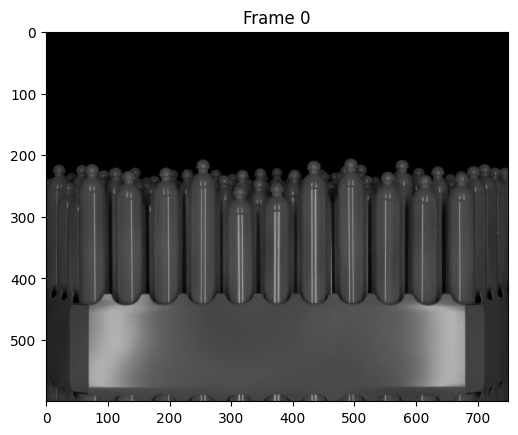

In [2]:
vidcap = cv2.VideoCapture(video_file)
success, frame = vidcap.read()
if success:
    plt.imshow(frame)
    plt.title(f"Frame 0")
    plt.show()
    

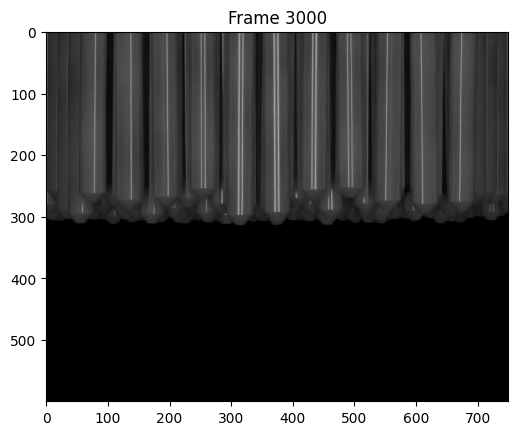

In [3]:
last_image = None
last_frame_number = 0
while success:
    last_image = frame
    success, frame = vidcap.read()
    last_frame_number += 1
plt.title(f"Frame {last_frame_number}")
plt.imshow(last_image)
plt.show()

In the video is cropped sequence which should be processed, this is not true in general and sometimes is necessary to set start/end frame. The code should look as follows:

In [167]:

start_frame = 100
stop_frame = last_frame_number - 100

# JK: originalni hodnoty
# start_frame = 120
# stop_frame = 240


# JK: POZOR, tohle nacte 5GB dat do pameti. To se nemusi vejit
# Muzem klidne brat kazdej druhej/treti frame

vidcap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
frames = []
for i in tqdm(range(start_frame, stop_frame),total=stop_frame-start_frame,desc='Reading Frames'):
    success, frame = vidcap.read()
    if success:
        # using only 1 channel
        frames.append(frame[:,:,0])
    else:
        print(f"WARNING: Frame {i} reading failed. Skipped!")

Reading Frames:   0%|          | 0/2800 [00:00<?, ?it/s]

In [170]:
HEIGHT,WIDTH = frames[0].shape[:2]

## Frame orientation

Setup of the scanning machine could not be ideal e.g. the camera is leaned. For this reason we try to fix the lean algorithmically. We try to find the angle by which the frame is rotated.

Because most of the frames contains just rods which are vertically oriented we assume, that correct frame rotation is reached when rods are oriented vertically.

### Houg transform

...

In [171]:
spacer_grid_frame_num = 400
edges = cv2.Canny(frames[spacer_grid_frame_num], 100, 200)

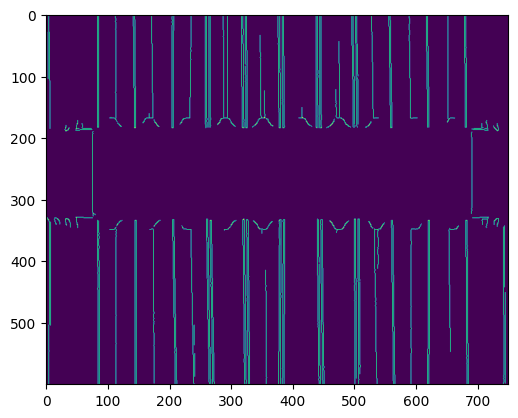

In [172]:
plt.imshow(edges)
plt.show()

In [173]:
hough_lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 80, minLineLength=200, maxLineGap=100)

In [174]:
hough_lines_angles = []
for x0, y0, x1, y1 in hough_lines[:,0,:]:
    if x1 != x0:
        line_angle = np.arctan((y1 - y0) / (x1 - x0))
    else:
        line_angle = np.pi/2
    hough_lines_angles.append(line_angle)

if len(hough_lines_angles) > 3:
    # rotation angle to reach vertical rods:
    rotation_angle = np.pi / 2 - np.nanmedian(hough_lines_angles)
    print(f"Rotation angle estimation: {np.rad2deg(rotation_angle)}°")
else:
    print(f"Not enough lines detected! Angle not set.")

Rotation angle estimation: 0.7957235527392704°


There should be a routine which fulfill missing angles. This happens especially on spacer grids where lower number of edge pixels are present and/or the lines are shorter.

We recommend to use bilinear interpolation of angles for frames where no valid angle was obtained. 

Finally, next steps should be done with rotated frames.

### Rotate image

In [175]:
def rotate_image(image, rotation_angle_rad):
    rotated_frame_target_shape = (WIDTH, HEIGHT)
    # NOTE: we expect existing angle for each frame - this assumption is not fulfilled in some cases
    degs = np.rad2deg(rotation_angle_rad)
    rotation_matrix = cv2.getRotationMatrix2D((WIDTH / 2, HEIGHT / 2), degs, 1)  # rotation is anticlockwise
    rotated_frame = cv2.warpAffine(image, rotation_matrix, rotated_frame_target_shape)
    
    return rotated_frame

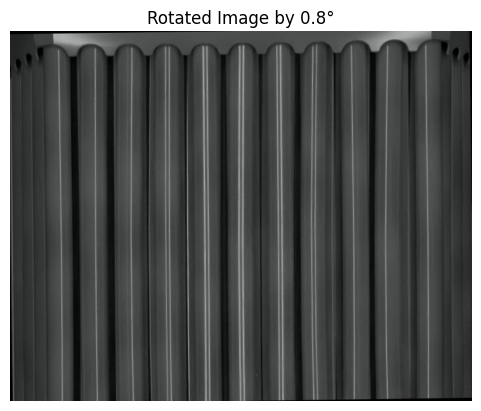

In [179]:
plt.imshow(rotate_image(frame, rotation_angle))
plt.title(f"Rotated Image by {np.rad2deg(rotation_angle):.1f}°")
plt.axis('off')
plt.show()

<span style="color:orange">TODO: Rotate all frames in the memory. Adapt code below to work with rotated frames.</span>

## Y-axis and camera speed

To precisely register frames we need to know camera speed. For the estimation of this speed we use spacer grids (SG) frames, where horizontal edges are present. We try to register frames containing the same SG and estimate the frame shift in direction of y-axis.

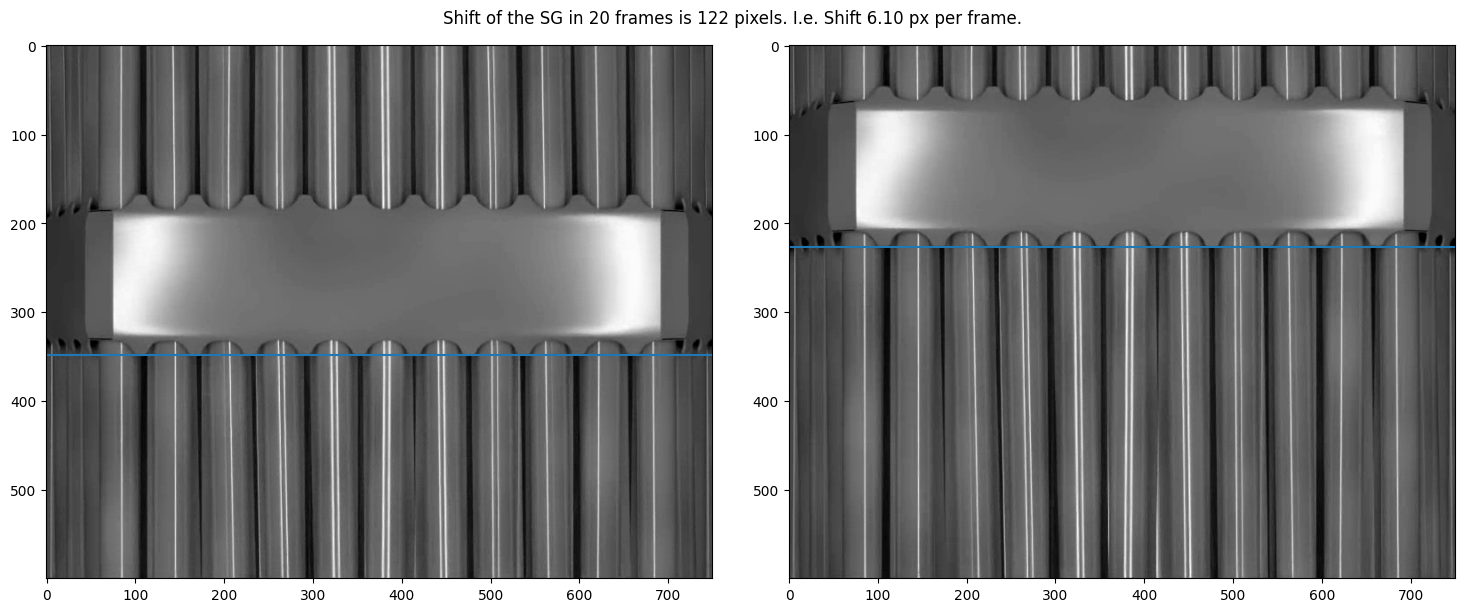

In [178]:
# We choose two frames with a SG

plt.figure(figsize=(15, 6))
ax = plt.subplot(1, 2, 1)

# Our SG is in this frame on a row 430
first_frame = spacer_grid_frame_num
# The first one is 20 frames before the second one i.e. 0.8s (with 25fps of the video)
ax.imshow(frames[first_frame],cmap='gray')

sg_pos_first_frame = 348
plt.axhline(sg_pos_first_frame)
ax = plt.subplot(1, 2, 2)
second_frame = first_frame +20
ax.imshow(frames[second_frame],cmap='gray')
# 20 frames later the position of the SG is at 331st row.
sg_pos_second_frame = 226
plt.axhline(sg_pos_second_frame)
plt.suptitle(f"Shift of the SG in {second_frame - first_frame} frames is {sg_pos_first_frame - sg_pos_second_frame} pixels. I.e. Shift {(sg_pos_first_frame - sg_pos_second_frame) / (second_frame - first_frame):.2f} px per frame.")
plt.tight_layout()
plt.show()

In [180]:
y_shift_of_consecutive_frames_px = (sg_pos_second_frame - sg_pos_first_frame) / (second_frame - first_frame)

The measurement of the camera speed is possible to do automatically and it will be useful to measure it on every spacer grid. Suggest some algorithm for robust camera speed estimation.

## Registration according to the X-axis

![x shift purpose](x-shift-purpose.png)

In [181]:
from scipy.optimize import minimize_scalar
from tqdm.auto import tqdm

As a metric for evaluation of x-shift ($\Delta x$), we use 

$$F(\Delta x, I_k, I_{k+1}) = \Sigma_{x \in \{0, ..., W\}} \left(I_k\left(x, \frac{H}{2}\right) - I_{k+1}\left(x + \Delta x, \frac{H}{2}\right)\right)^2,$$

where

- $I_k$, $I_{k+1}$ denotes function, which for pixel coordinates $[x,y]$ return intensity of that pixel in frame $k$, $k+1$ respectively
- $W$, $H$ is a width (height) of a frame in input video  

This product is maximal, when intensities of $I_{k+1}$ shifted by $\Delta x$ exactly matches intensities in $I_k$ at non-shifted positions.

Shift should be with subpixel precision.

In [184]:
x_shifts = [0]
prev_frame = frames[0]
for current_frame in tqdm(frames[1:], total=len(frames)-1, desc="X-shift computation"):
    def subpixel_shift_error(x_shift):
        interpolated = np.interp(np.arange(x_shift, x_shift + WIDTH), 
                  np.arange(WIDTH),
                  current_frame[int(np.round(HEIGHT // 2 + y_shift_of_consecutive_frames_px)), :] / 255.0)
        
        return np.sum(np.power(prev_frame[HEIGHT // 2, :] / 255.0 - interpolated, 2))        
    
    # We use minimization function to find correct position with subpixel precision
    best_shift = minimize_scalar(
        subpixel_shift_error,
        0,
        bounds=(-1, +1), # We expect small shift along the x-axis (it is in pixels per 0.04s)
        method='Bounded',        
    )    
    x_shifts.append(best_shift.x)
    prev_frame = current_frame

X-shift computation:   0%|          | 0/2799 [00:00<?, ?it/s]

In [185]:
# Meaning of the x_shift is relevant for OIO as a cummulative sum
x_shifts_cum = np.cumsum(np.array(x_shifts))

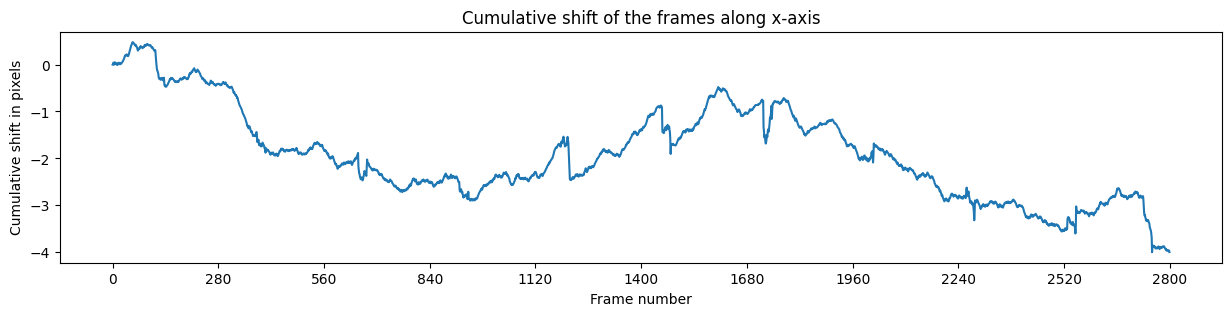

In [186]:
plt.figure(figsize=(15, 3))
plt.title("Cumulative shift of the frames along x-axis")
plt.plot(x_shifts_cum)
plt.xlabel("Frame number")
plt.ylabel("Cumulative shift in pixels")
x_ticks = np.linspace(0, stop_frame-start_frame, 11)
x_labels = np.linspace(0, stop_frame-start_frame, 11,dtype=int)
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.show()

# Danger Zone

  0%|          | 0/2800 [00:00<?, ?it/s]

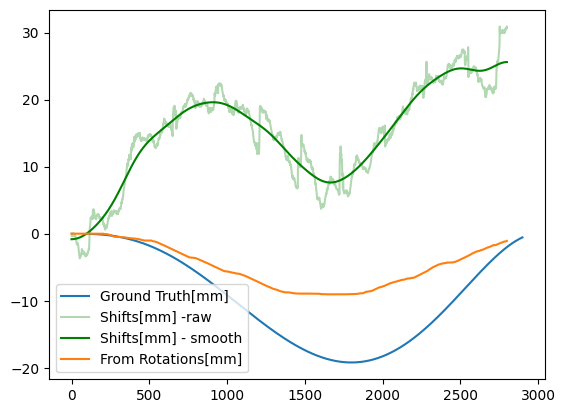

In [187]:
# POZOR, toto dokazuje ze to nefunguje

frame_orientations_rad = []
for frame in tqdm(frames):
    edges = cv2.Canny(frame, 100, 200)
    #hough_lines = cv2.HoughLines(edges, 1, np.pi / 720, 80, minLineLength=200, maxLineGap=100,min_theta = np.pi/2-np.pi/20,max_theta = np.pi/2+np.pi/20)

    # TRANSPOSITION HERE
    hough_lines = cv2.HoughLines(edges.T, 1, np.pi / 720*2, 80, min_theta = np.pi/2-np.pi/20,max_theta = np.pi/2+np.pi/20)
    if hough_lines is None:
        frame_orientations_rad.append(0)
        continue
        
    hough_lines_angles = []    
    for _,theta in hough_lines[:,0,:]:
        line_angle = theta + np.pi/2
        
        if line_angle > np.pi/2:
            line_angle -= np.pi
        # # filter horizontal
        if np.abs(line_angle) < np.pi/16:
            hough_lines_angles.append(line_angle)

    if len(hough_lines_angles) > 3:
        # rotation angle to reach vertical rods:
        rotation_angle = np.nanmedian(hough_lines_angles)
    else:
        rotation_angle = 0
    
    frame_orientations_rad.append(rotation_angle)
    
frame_orientations_rad = np.array(frame_orientations_rad)
tans = np.tan(frame_orientations_rad)
shifts_from_rot = tans * cam_speed_mm
cum_shifts_from_rot = np.cumsum(shifts_from_rot)

import scipy.ndimage as ndi
import pandas as pd
df_shifts = pd.read_csv('data/shifts.csv')
df_shifts = df_shifts.iloc[start_frame:stop_frame]

cam_speed_mm = 3800/3000
px_to_mm = y_shift_of_consecutive_frames_px * cam_speed_mm
cam_shift_mm
abs_shifts_x = df_shifts['abs_shift_x_mm'] 
plt.plot(abs_shifts_x, label ="Ground Truth[mm]")
plt.plot(x_shifts_cum * px_to_mm,label="Shifts[mm] -raw ",alpha=.3,c = 'green')
plt.plot(ndi.gaussian_filter1d(x_shifts_cum * px_to_mm,100),c = 'green',label="Shifts[mm] - smooth")
plt.plot(-cum_shifts_from_rot,label='From Rotations[mm]')
plt.legend()

# END of danger zone

Check the registration quality on some shifted frames. Visualize the registration output:

In [188]:
from scipy.interpolate import RectBivariateSpline

In [205]:
# as a reference frame we use frame with id start_frame + 50
ref_frame_id = start_frame + 60
# for comparison we use frame with id start_frame + 97
compared_frame_id = start_frame + 50 # Up to 47 diff in horizontal shift
# in the image we show just this number of lines
compared_frame_height = 100
# linse will be centered around this row
h_center = HEIGHT // 2

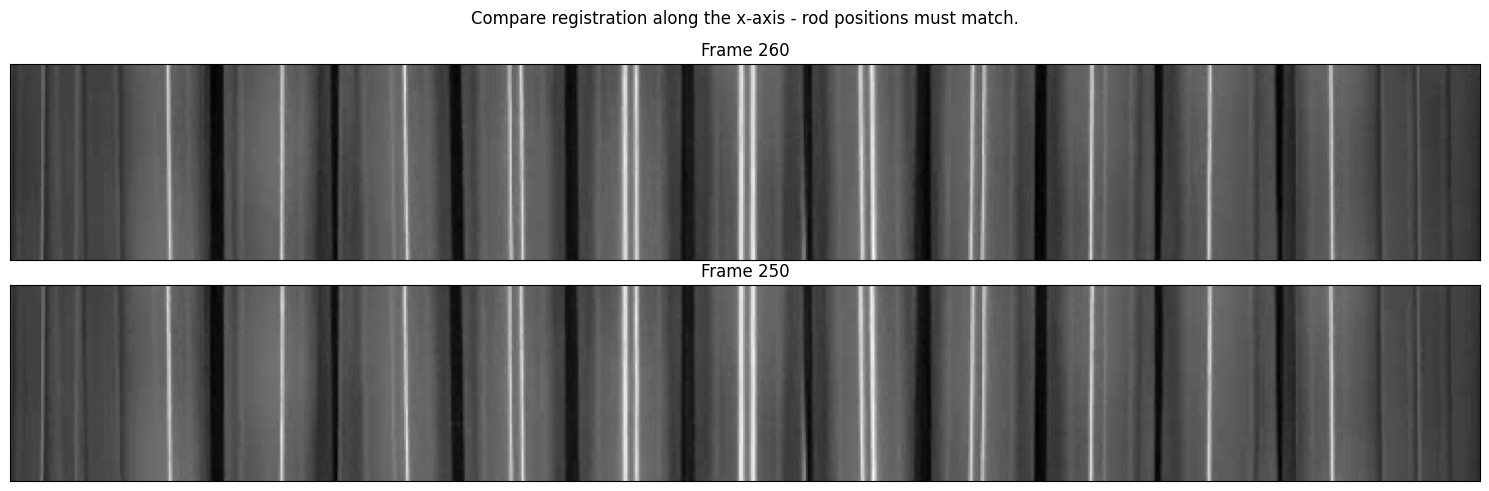

In [207]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(2, 1, 1)
ax.set_title(f"Frame {ref_frame_id + start_frame}")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(frames[ref_frame_id][h_center - compared_frame_height // 2: h_center + compared_frame_height // 2, :],cmap='gray')

ax = plt.subplot(2, 1, 2)
ax.set_title(f"Frame {compared_frame_id + start_frame}")

x_shift = x_shifts_cum[compared_frame_id] - x_shifts_cum[ref_frame_id]
y_shift = np.round(y_shift_of_consecutive_frames_px * (compared_frame_id - ref_frame_id)).astype(int)

spline = RectBivariateSpline(
    x=np.arange(WIDTH), 
    y=np.arange(compared_frame_height), 
    z=frames[compared_frame_id][
      (h_center + y_shift).astype(int) - compared_frame_height // 2: 
      (h_center + y_shift).astype(int) - compared_frame_height // 2 + compared_frame_height, :].T
)

xgrid, ygrid = np.meshgrid(
    np.arange(x_shift, x_shift + WIDTH), 
    np.arange(compared_frame_height)
)

ax.imshow(spline(xgrid, ygrid, grid=False), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
plt.suptitle("Compare registration along the x-axis - rod positions must match.")
plt.tight_layout()
plt.show()

## One image overview construction

In previous part, we computed frame: 
- rotation angles $\alpha$
- y-shift $\Delta y$
- x-shift $\Delta x$

From these values we are able to extract pixels from each frame which together build up the One Image Overview

In [211]:
y_shifts = np.ones((len(x_shifts), )) * -y_shift_of_consecutive_frames_px
rotation_angles = np.ones((len(x_shifts), )) * rotation_angle

In [212]:
# Frame slice denotes area which is used for OIO construction.
# In principle, we do not necessarily use the central part of the frame.
# We can use bottom or upper part of the frame as well. 
# By this change, we can e.g. produce OIOs with different light conditions.
# If you want to change the slice used for OIO construction set this variable to 0.1 (upper part) or 0.9 (bottom part)
frame_slice_start = 0.5

# We can blend the output from several frames. This can be useful especially in cases when data are noisy (i.e. strong radiation causes salt and pepper noise in images). In opposite, blending causes blurred output in cases when registration parameters were not properly estimated.
# 3 pixels is conservative blending. More is better for noisy frames, less is better in case of problematic registration.
averaged_pixels = 3

In [215]:
oio_height = int(np.sum(y_shifts))
oio_width = int(np.max(x_shifts_cum) - np.min(x_shifts_cum) + WIDTH)

accumulator = np.zeros((np.abs(oio_height), oio_width)).astype(float)
weights = np.zeros((np.abs(oio_height), oio_width))
# According to the direction of the camera movement we have to set up starting position
position = 0 if oio_height > 0 else np.abs(oio_height) + y_shifts[0]

for frame, (idx, rotation_angle_rad) in zip(frames, enumerate(rotation_angles)):
    rotated = rotate_image(frame / 255.0, rotation_angle_rad)

    slice_start = np.floor(HEIGHT * frame_slice_start).astype(int) - 1
    slice_height = np.abs(np.sum(y_shifts[idx: np.min([idx + averaged_pixels, y_shifts.size])]).astype(int))
    if position + slice_height > np.abs(oio_height):
        slice_height = np.abs(oio_height) - position
    slice_end = np.ceil(slice_start + slice_height).astype(int) + 1

    row_px_position = np.arange(x_shifts_cum[idx], x_shifts_cum[idx] + WIDTH, 1)
    acc_row_px_position = slice(0, WIDTH)

    acc_target = np.arange(np.floor(position).astype(int), np.ceil(position + slice_height).astype(int))
    extra_line = int(len(acc_target) - (slice_end - slice_start - 2))  # there is extra line
    row_weight = np.array([1 - (position % 1)] + [1 for _ in range(acc_target.size - 2)] + [(position + slice_height) % 1]).reshape(-1, 1)
    
    interpolated = RectBivariateSpline(x=np.arange(slice_start, slice_end),
                                       y=np.arange(rotated.shape[1]),
                                       z=rotated[slice_start: slice_end, :],
                                       kx=np.min([slice_end - slice_start - 1, 3]))

    accumulator[acc_target, acc_row_px_position] += interpolated(np.arange(slice_start + 1, slice_end - 1 + extra_line), row_px_position) * row_weight

    
    weights[acc_target, acc_row_px_position] += np.ones((acc_target.size, row_px_position.size)) * row_weight

    position += y_shifts[idx]

oio = accumulator
oio[weights != 0] = accumulator[weights != 0] / weights[weights != 0]
oio = ((oio - np.min(oio)) * 255 / (np.max(oio) - np.min(oio))).astype(np.uint8)

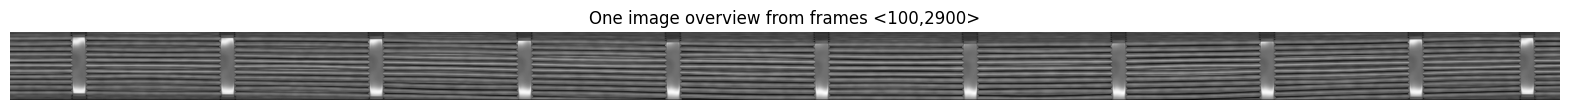

In [220]:
plt.figure(figsize=(20,4))
plt.title(f"One image overview from frames <{start_frame},{stop_frame}>")
plt.imshow(oio.T,cmap='gray')
plt.axis('off')
plt.show()